In [1]:
import numpy as np
from scipy import stats
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate data according to the model
def generate_data(n):
    # Generate correlation matrix Sigma with Sigma_ij = 0.8^|i-j|
    Sigma = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            Sigma[i, j] = 0.8 ** abs(i - j)
    
    # Generate x_i ~ N(0, Sigma)
    X = np.random.multivariate_normal(np.zeros(3), Sigma, n)
    
    # Generate z_i ~ Bernoulli(rho)
    Z = np.random.binomial(1, rho, size=(n, 1))
    
    # Generate epsilon_i ~ t_5(0, 1.5)
    epsilon = (1.5 + X[:,0] ** 2) * stats.t.rvs(df=3, size=n)
    
    # Compute y according to the model
    y = 1 - 2 * X[:, 0]**2 - 2 * np.sin(X[:, 1]) + 3 * np.abs(X[:, 2]) + Z.flatten() * delta_0 + epsilon
    
    # Create design matrix W = [1, x_i1^2, sin(x_i2), |x_i3|, z_i]
    W = np.column_stack((
        np.ones(n),       # Intercept
        X[:, 0]**2,       # x_i1^2
        np.sin(X[:, 1]),  # sin(x_i2)
        np.abs(X[:, 2]),  # |x_i3|
        Z                 # z_i
    ))
    
    return W, y

# Compute OLS estimates at each step with rank-1 updates
def compute_sequential_estimates(W_all, y_all):
    n_samples = len(y_all)
    n_min = p + d + 2  # Minimum sample size to start with
    
    # Arrays to store results
    delta_hats = np.full(n_samples, np.nan)  # Store as NaN until computable
    s_squared_vals = np.full(n_samples, np.nan)
    
    # Matrix for storing Sigma_delta at each step
    Sigma_deltas = np.full((n_samples, d, d), np.nan)
    
    # Matrix for storing (Z'Z)^-1 at each step for F statistic calculation
    ZtZ_invs = np.full((n_samples, d, d), np.nan)
    
    # Indicator of when estimates become valid
    valid_indices = []
    
    # Precompute all outer products of W_all rows - this is a key optimization
    # This will be a 3D array of shape (n_samples, p+d, p+d)
    W_outer_products = np.zeros((n_samples, W_all.shape[1], W_all.shape[1]))
    for i in range(n_samples):
        W_outer_products[i] = np.outer(W_all[i], W_all[i])
    
    # Find the minimum n where W'W is invertible
    n_init = n_min
    invertible = False
    
    while n_init <= n_samples and not invertible:
        W_init = W_all[:n_init, :]
        WtW = W_init.T @ W_init
        
        # Check if matrix is invertible
        if np.linalg.matrix_rank(WtW) == WtW.shape[0]:
            invertible = True
        else:
            n_init += 1

    W_init = W_all[:n_init, :]
    y_init = y_all[:n_init]
    WtW = W_init.T @ W_init
    Wty = W_init.T @ y_init
    WtW_inv = np.linalg.inv(WtW)
    gamma_hat = WtW_inv @ Wty
    
    # Extract delta_hat
    delta_hat = gamma_hat[p:p+d]
    
    # Compute s^2
    y_hat = W_init @ gamma_hat
    residuals = y_init - y_hat
    RSS = residuals.T @ residuals
    s_squared = RSS / (n_init - p - d)
    
    # Compute Omega_W_n and its inverse
    Omega_W_n = (1/n_init) * WtW
    Omega_W_n_inv = np.linalg.inv(Omega_W_n)
    Omega_W_n_inv_old = Omega_W_n_inv.copy()  # Store for recursive updates
    
    # Using einsum for efficient computation of Sigma_n
    Sigma_n = np.einsum('i,ijk->jk', residuals**2, W_outer_products[:n_init]) / (n_init - p - d)
    
    # Selection matrix
    E = np.zeros((d, p + d))
    E[:, p:] = np.eye(d)
    
    # Compute Sigma_delta_n
    Sigma_delta_n = E @ Omega_W_n_inv @ Sigma_n @ Omega_W_n_inv @ E.T
    
    # Extract (Z'Z)^-1 from WtW_inv for F statistic calculation
    # This is the lower right d×d submatrix of WtW_inv
    ZtZ_inv = WtW_inv[p:p+d, p:p+d]
    
    # Store initial results
    delta_hats[n_init-1] = delta_hat[0]
    s_squared_vals[n_init-1] = s_squared
    Sigma_deltas[n_init-1, :, :] = Sigma_delta_n
    ZtZ_invs[n_init-1, :, :] = ZtZ_inv
    valid_indices.append(n_init-1)
    
    # Now use rank-1 updates for subsequent observations
    for n in range(n_init+1, n_samples+1):
        # Get new observation
        w_new = W_all[n-1, :]
        y_new = y_all[n-1]
        
        # Sherman-Morrison formula for rank-1 update of inverse
        denom = 1 + w_new @ WtW_inv @ w_new

        # Update WtW_inv using Sherman-Morrison with precomputed outer product
        WtW_inv_update = WtW_inv - (WtW_inv @ W_outer_products[n-1] @ WtW_inv) / denom
        WtW_inv = WtW_inv_update
        
        # Update WtW with precomputed outer product
        WtW = WtW + W_outer_products[n-1]
        
        # Update Wty
        Wty = Wty + w_new * y_new
    
        # Compute gamma_hat with updated matrices
        gamma_hat = WtW_inv @ Wty
        
        # Extract delta_hat
        delta_hat = gamma_hat[p:p+d]
        
        # Update RSS (residual sum of squares)
        # We also need to recompute all residuals since gamma_hat changed
        y_hat_all = W_all[:n, :] @ gamma_hat
        residuals_all = y_all[:n] - y_hat_all
        RSS = residuals_all.T @ residuals_all
        
        # Update s^2
        s_squared = RSS / (n - p - d)
        
        # Update Omega_W_n and its inverse using similar rank-1 update
        if n == n_init+1:
            # For first update, initialize Omega_W_n and its inverse
            Omega_W_n_old = (1/(n-1)) * (WtW - W_outer_products[n-1])
            Omega_W_n = (1/n) * WtW
            Omega_W_n_inv = np.linalg.inv(Omega_W_n)
        else:
            # For subsequent updates, use rank-1 update for Omega_W_n_inv
            Omega_W_n_old = Omega_W_n.copy()
            Omega_W_n = ((n-1)/n) * Omega_W_n_old + (1/n) * W_outer_products[n-1]
            
            # Compute rank-1 update for Omega_W_n_inv using Woodbury identity
            scale = (n-1)/n
            
            scaled_inv_old = (1/scale) * Omega_W_n_inv_old
            denom = scale + w_new @ Omega_W_n_inv_old @ w_new / n
            
            if abs(denom) < 1e-10:
                # If near-singular, compute directly
                Omega_W_n_inv = np.linalg.inv(Omega_W_n)
            else:
                adjustment = (scaled_inv_old @ W_outer_products[n-1] @ scaled_inv_old) / (n * denom)
                Omega_W_n_inv = scaled_inv_old - adjustment
        
        # Store the current inverse for next iteration
        Omega_W_n_inv_old = Omega_W_n_inv
        
        # Using einsum for efficient computation of Sigma_n
        Sigma_n = np.einsum('i,ijk->jk', residuals_all**2, W_outer_products[:n]) / (n - p - d)
        
        # Compute Sigma_delta_n
        Sigma_delta_n = E @ Omega_W_n_inv @ Sigma_n @ Omega_W_n_inv @ E.T
        
        # Extract (Z'Z)^-1 from WtW_inv for F statistic calculation
        ZtZ_inv = WtW_inv[p:p+d, p:p+d]
        
        # Store results
        delta_hats[n-1] = delta_hat[0]
        s_squared_vals[n-1] = s_squared
        Sigma_deltas[n-1, :, :] = Sigma_delta_n
        ZtZ_invs[n-1, :, :] = ZtZ_inv
        valid_indices.append(n-1)
    
    return delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices

# Compute F_n, G_n, E_n, and H_n for various g values
def compute_statistics_for_g(delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices, g_value):
    n_samples = len(delta_hats)
    
    # Initialize arrays
    F_ns = np.full(n_samples, np.nan)
    G_ns = np.full(n_samples, np.nan)
    E_ns = np.full(n_samples, np.nan)
    H_ns = np.full(n_samples, np.nan)  # New array for H_n
    
    for idx in valid_indices:
        n = idx + 1  # Convert to 1-based indexing
        delta_hat = delta_hats[idx]
        s_squared = s_squared_vals[idx]
        Sigma_delta = Sigma_deltas[idx]
        ZtZ_inv = ZtZ_invs[idx]
        
        # Compute F_n using the correct formula: F_n = (δ'(Z'Z)δ) / (d * s²)
        if d == 1:
            # For d=1, simplify to scalar operations
            F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)
        else:
            # For d>1, use matrix operations
            F_n = (delta_hat.T @ np.linalg.inv(ZtZ_inv) @ delta_hat) / (d * s_squared)
        
        # Degrees of freedom
        nu_n = n - p - d
        
        # Compute G_n with correct F_n
        factor1 = (g_value / (g_value + n)) ** (d / 2)
        factor2 = (1 + (g_value / (g_value + n)) * (d / nu_n) * F_n) / (1 + (d / nu_n) * F_n)
        factor2 = factor2 ** (-(nu_n + d) / 2)
        
        G_n = factor1 * factor2
        
        # Compute quadratic term for E_n and H_n
        try:
            # For d=1, simplify the quadratic term
            if d == 1:
                Sigma_delta_inv = 1/float(Sigma_delta)
                quadratic_term = delta_hat * Sigma_delta_inv * delta_hat
            else:
                Sigma_delta_inv = np.linalg.inv(Sigma_delta)
                quadratic_term = delta_hat.T @ Sigma_delta_inv @ delta_hat
            
            # Compute E_n
            E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
            
            # Compute Q_n and H_n
            Q_n = n * quadratic_term / d
            factor1_H = (g_value / (g_value + n)) ** (d / 2)
            factor2_H = (1 + (g_value / (g_value + n)) * (d / nu_n) * Q_n) / (1 + (d / nu_n) * Q_n)
            factor2_H = factor2_H ** (-(nu_n + d) / 2)
            H_n = factor1_H * factor2_H
            
        except np.linalg.LinAlgError:
            E_n = np.nan
            H_n = np.nan
            
        # Store computed values
        F_ns[idx] = F_n
        G_ns[idx] = G_n
        E_ns[idx] = E_n
        H_ns[idx] = H_n
    
    return F_ns, G_ns, E_ns, H_ns

# Find first crossing times for various thresholds
def find_crossings(G_ns, E_ns, H_ns, alpha):
    threshold = 1 / alpha
    
    # Find first index where G_n > threshold
    G_indices = np.where(G_ns > threshold)[0]
    first_G_crossing = G_indices[0] + 1 if len(G_indices) > 0 else None
    
    # Find first index where E_n > threshold
    E_indices = np.where(E_ns > threshold)[0]
    first_E_crossing = E_indices[0] + 1 if len(E_indices) > 0 else None
    
    # Find first index where H_n > threshold
    H_indices = np.where(H_ns > threshold)[0]
    first_H_crossing = H_indices[0] + 1 if len(H_indices) > 0 else None
    
    return first_E_crossing, first_G_crossing, first_H_crossing

# Run a single simulation
def run_single_simulation():
    # Generate data once
    W_all, y_all = generate_data(n_total)
    
    # Compute OLS estimates and variances for all sample sizes
    delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices = compute_sequential_estimates(W_all, y_all)
    
    # For each g value, compute statistics
    results = {}
    for g_value in g_values:
        F_ns, G_ns, E_ns, H_ns = compute_statistics_for_g(delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices, g_value)
        
        # For each alpha, find crossing times
        crossings = {}
        for alpha in alpha_values:
            first_E_crossing, first_G_crossing, first_H_crossing = find_crossings(G_ns, E_ns, H_ns, alpha)
            crossings[alpha] = (first_E_crossing, first_G_crossing, first_H_crossing)
        
        results[g_value] = {
            'F_ns': F_ns,
            'G_ns': G_ns,
            'E_ns': E_ns,
            'H_ns': H_ns,  # Store H_ns
            'crossings': crossings
        }
    
    return results

# Run multiple simulations
def run_multiple_simulations():
    all_results = {}
    
    for g_value in g_values:
        all_results[g_value] = {}
        
        for alpha in alpha_values:
            all_results[g_value][alpha] = {
                'E_crossings': [],
                'G_crossings': [],
                'H_crossings': []  # Add H_crossings
            }
    
    print(f"Running {n_simulations} simulations...")
    for sim in tqdm(range(n_simulations)):
        np.random.seed(42 + sim)  # Different seed for each simulation
        
        # Run a single simulation with all g and alpha values
        sim_results = run_single_simulation()
        
        # Extract and store crossing times
        for g_value in g_values:
            for alpha in alpha_values:
                first_E, first_G, first_H = sim_results[g_value]['crossings'][alpha]
                all_results[g_value][alpha]['E_crossings'].append(first_E)
                all_results[g_value][alpha]['G_crossings'].append(first_G)
                all_results[g_value][alpha]['H_crossings'].append(first_H)
    
    # Compute summary statistics
    for g_value in g_values:
        for alpha in alpha_values:
            # Get crossing data
            E_crossings = all_results[g_value][alpha]['E_crossings']
            G_crossings = all_results[g_value][alpha]['G_crossings']
            H_crossings = all_results[g_value][alpha]['H_crossings']
            
            # Compute probabilities
            prob_E = np.mean([x is not None for x in E_crossings])
            prob_G = np.mean([x is not None for x in G_crossings])
            prob_H = np.mean([x is not None for x in H_crossings])
            
            # Compute average crossing times (when they exist)
            valid_E = [x for x in E_crossings if x is not None]
            valid_G = [x for x in G_crossings if x is not None]
            valid_H = [x for x in H_crossings if x is not None]
            
            avg_E = np.mean(valid_E) if valid_E else None
            avg_G = np.mean(valid_G) if valid_G else None
            avg_H = np.mean(valid_H) if valid_H else None
            
            # Store summary statistics
            all_results[g_value][alpha]['prob_E'] = prob_E
            all_results[g_value][alpha]['prob_G'] = prob_G
            all_results[g_value][alpha]['prob_H'] = prob_H
            all_results[g_value][alpha]['avg_E'] = avg_E
            all_results[g_value][alpha]['avg_G'] = avg_G
            all_results[g_value][alpha]['avg_H'] = avg_H
    
    return all_results



def plot_cumulative_stopping_times(results, alpha=0.05, n_total=1000, n_simulations=1000, ylim_max=1):
    """
    Plot the cumulative proportion of simulations that have stopped by time n.
    
    Parameters:
    -----------
    results : dict
        The nested dictionary returned by the run_multiple_simulations function.
    alpha : float, default=0.05
        The significance level to use for the analysis.
    n_total : int, default=1000
        Total number of observations in each simulation.
    n_simulations : int, default=1000
        Number of simulations run.
    ylim_max : float, default=1
        Maximum y-axis limit for the plot.
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot.
    """
    # Set up the plot
    plt.figure(figsize=(15, 5))
    
    # Define line styles and colors for different g values and statistics
    g_values = list(results.keys())
    line_styles = ['-', '--',  ':', '-.',]
    colors = ['blue', 'red', 'green']  # Added green for H_n
    
    # Prepare data for plotting
    x = np.arange(1, n_total + 1)
    
    # Plot cumulative stopping times for each g value
    for i, g in enumerate(g_values):
        # Get stopping times for E_n
        E_crossings = results[g][alpha]['E_crossings']
        
        # Convert None to n_total + 1 (never stopped)
        E_crossings = [n if n is not None else n_total + 1 for n in E_crossings]
        
        # Calculate cumulative proportion that stopped by each time point
        cum_stops_E = np.array([np.mean([stop <= n for stop in E_crossings]) for n in x])
        
        # Plot E_n stopping times
        plt.plot(x, cum_stops_E, 
                 linestyle=line_styles[i % len(line_styles)], 
                 color=colors[0],
                 label=f'$E^G_n, g={g}$')
        
        # Get stopping times for G_n
        G_crossings = results[g][alpha]['G_crossings']
        
        # Convert None to n_total + 1 (never stopped)
        G_crossings = [n if n is not None else n_total + 1 for n in G_crossings]
        
        # Calculate cumulative proportion that stopped by each time point
        cum_stops_G = np.array([np.mean([stop <= n for stop in G_crossings]) for n in x])
        
        # Plot G_n stopping times
        plt.plot(x, cum_stops_G, 
                 linestyle=line_styles[i % len(line_styles)], 
                 color=colors[1],
                 label=f'$G_n, g={g}$')
        
        # Get stopping times for H_n
        H_crossings = results[g][alpha]['H_crossings']
        
        # Convert None to n_total + 1 (never stopped)
        H_crossings = [n if n is not None else n_total + 1 for n in H_crossings]
        
        # Calculate cumulative proportion that stopped by each time point
        cum_stops_H = np.array([np.mean([stop <= n for stop in H_crossings]) for n in x])
        
        # Plot H_n stopping times
        plt.plot(x, cum_stops_H, 
                 linestyle=line_styles[i % len(line_styles)], 
                 color=colors[2],
                 label=f'$E_n, g={g}$')
    
    plt.axhline(y=alpha, linestyle='dashed', color='black', label=f"α = {alpha}")
    
    # Customize the plot
    plt.xlabel('Sample Size (n)', fontsize=12)
    plt.ylabel('Proportion of Nulls Rejected', fontsize=12)
    plt.legend(loc='upper right', framealpha=1, facecolor='white', edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set axis limits
    plt.ylim(0, ylim_max)
    plt.xlim(0, n_total)
    
    plt.tight_layout()
    return plt.gcf()


# Null Simulation

In [2]:
# Parameters
n_total = 10000  # Total number of observations
p = 4  # Number of x covariates (including intercept)
d = 1  # Dimension of z
rho = 0.5  # Probability for Bernoulli
delta_0 = 0.0  # True value of delta
n_simulations = 1000  # Number of simulations to run

# Alpha and g parameter grids
alpha_values = [0.05]
g_values = [1, 10, 1000]

results_null = run_multiple_simulations()

Running 1000 simulations...


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_1820767/1294574603.py:218: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)
/tmp/ipykernel_1820767/1294574603.py:237: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_delta_inv = 1/float(Sigma_delta)
 14%|█▍        | 141/1000 [02:10<13:12,  1.08it/s]/tmp/ipykernel_1820767/1294574603.py:244: RuntimeWarning: overflow encountered in exp
  E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
100%|██████████| 1000/1000 [15:28<00:00,  1.08it/s]


In [3]:
# save results

import pickle

filepath = 'simulated_example_null.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(results_null, f)

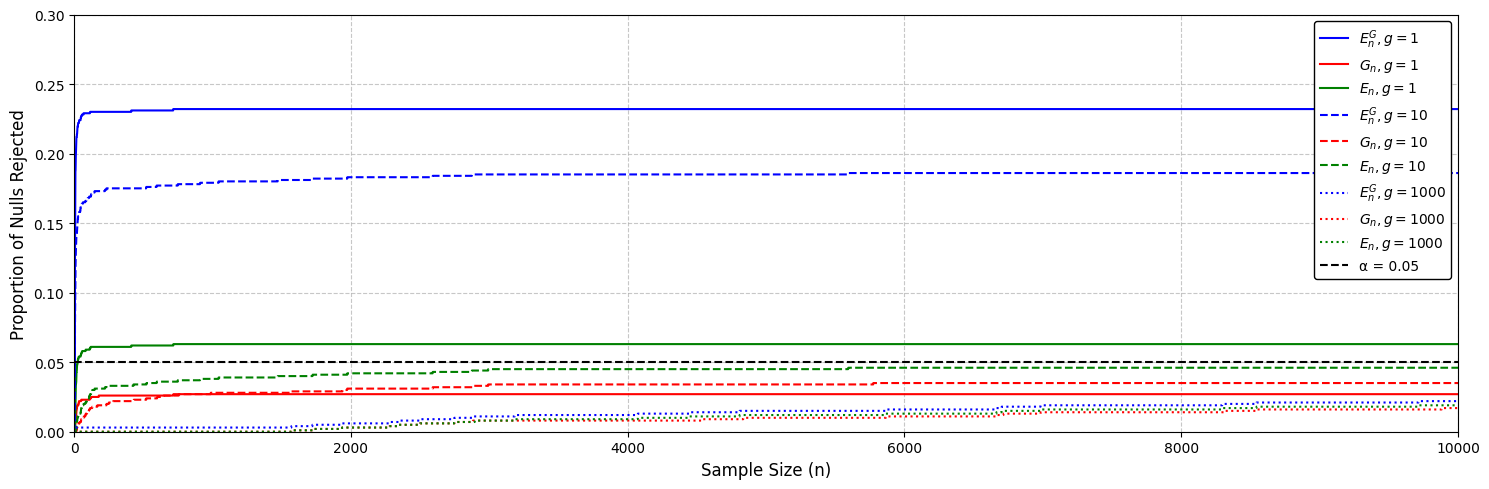

In [4]:
# plot results

fig = plot_cumulative_stopping_times(results_null, n_total=10000, alpha=0.05, ylim_max=0.3)
plt.savefig('simulated_example_null.png', dpi=300)
plt.show()

# Alternative Simulation



In [5]:
n_total = 5000  # Total number of observations
delta_0 = 1.0  # True value of delta

In [6]:
results_alt = run_multiple_simulations()

Running 1000 simulations...


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_1820767/1294574603.py:218: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)
/tmp/ipykernel_1820767/1294574603.py:237: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_delta_inv = 1/float(Sigma_delta)
100%|██████████| 1000/1000 [05:45<00:00,  2.89it/s]


In [7]:
import pickle

filepath = 'simulated_example_alternative.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(results_alt, f)

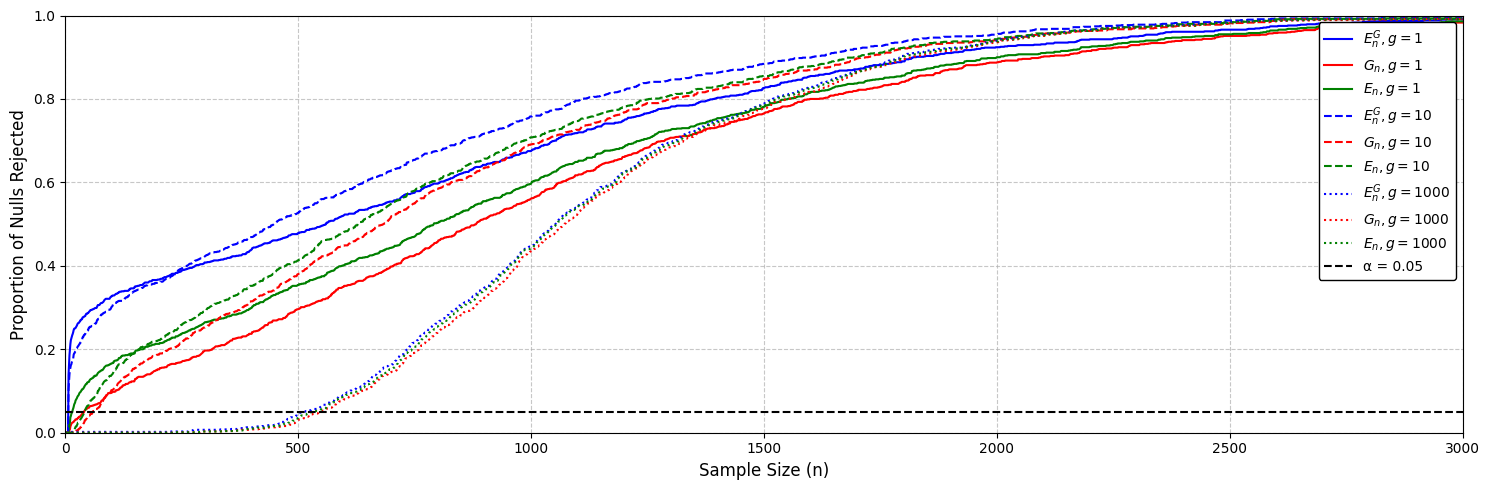

In [8]:
fig = plot_cumulative_stopping_times(results_alt, n_total=3000, alpha=0.05, ylim_max=1)
plt.savefig('simulated_example_alternative.png', dpi=300)
plt.show()